In [1]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [56]:
root_folder = "./val_spectogram_label/"

In [57]:
os.makedirs(root_folder)

In [58]:
os.makedirs(os.path.join(root_folder, 'neutral'), exist_ok=True)
os.makedirs(os.path.join(root_folder, 'surprise'), exist_ok=True)
os.makedirs(os.path.join(root_folder, 'anger'), exist_ok=True)
os.makedirs(os.path.join(root_folder, 'joy'), exist_ok=True)
os.makedirs(os.path.join(root_folder, 'sadness'), exist_ok=True)
os.makedirs(os.path.join(root_folder, 'disgust'), exist_ok=True)
os.makedirs(os.path.join(root_folder, 'fear'), exist_ok=True)

In [33]:
import csv
import shutil

def split_data_into_label_folder(data_dir, file_path):
    with open(file_path, 'r', newline='') as csv_file:
        csv_reader = csv.DictReader(csv_file, delimiter=',')
        header = csv_reader.fieldnames
        print("start iteration")
        print(header)

        for row in csv_reader:
            try:
                file_name = "dia" + row['Dialogue_ID'] + "_utt" + row['Utterance_ID']
                #print(file_name)
                input_mfcc_path = data_dir + file_name + ".png"
                print(input_mfcc_path)
                output_mfcc_path = root_folder + row['Emotion'] + "/" + file_name + ".png"
                print(output_mfcc_path)
                shutil.move(input_mfcc_path, output_mfcc_path)

            except FileNotFoundError:
                print("Error: The specified file does not exist.")
            except Exception as e:
                print(f"Error: {e}")

    print("CSV file reading and iteration completed.")
    

In [4]:
def split_data_into_dataset_ratio(data_dir, train_ratio=0.8, val_ratio=0.15):
    classes = os.listdir(data_dir)
    for label in classes:
        label_dir = os.path.join(data_dir, label)
        file_list = os.listdir(label_dir)
        random.shuffle(file_list)

        train_cutoff = int(len(file_list) * train_ratio)
        val_cutoff = int(len(file_list) * (train_ratio + val_ratio))

        train_files = file_list[:train_cutoff]
        val_files = file_list[train_cutoff:val_cutoff]
        test_files = file_list[val_cutoff:]

        train_dir = os.path.join(data_dir, 'train', label)
        val_dir = os.path.join(data_dir, 'validation', label)
        test_dir = os.path.join(data_dir, 'test', label)

        
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        for file in train_files:
            shutil.copy(os.path.join(label_dir, file), os.path.join(train_dir, file))
        for file in val_files:
            shutil.copy(os.path.join(label_dir, file), os.path.join(val_dir, file))
        for file in test_files:
            shutil.copy(os.path.join(label_dir, file), os.path.join(test_dir, file))


In [59]:
data_dir = './val_spectogram/'

split_data_into_label_folder(data_dir, "./validation_data.csv")

start iteration
['Dialogue_ID', 'Utterance_ID', 'Utterance', 'Emotion']
./val_spectogram/dia482_utt14.png
./val_spectogram_label/neutral/dia482_utt14.png
./val_spectogram/dia253_utt10.png
./val_spectogram_label/joy/dia253_utt10.png
./val_spectogram/dia153_utt2.png
./val_spectogram_label/neutral/dia153_utt2.png
./val_spectogram/dia547_utt0.png
./val_spectogram_label/surprise/dia547_utt0.png
./val_spectogram/dia64_utt9.png
./val_spectogram_label/anger/dia64_utt9.png
./val_spectogram/dia414_utt6.png
./val_spectogram_label/neutral/dia414_utt6.png
./val_spectogram/dia961_utt7.png
./val_spectogram_label/neutral/dia961_utt7.png
./val_spectogram/dia450_utt19.png
./val_spectogram_label/surprise/dia450_utt19.png
./val_spectogram/dia929_utt5.png
./val_spectogram_label/neutral/dia929_utt5.png
./val_spectogram/dia771_utt3.png
./val_spectogram_label/neutral/dia771_utt3.png
./val_spectogram/dia72_utt5.png
./val_spectogram_label/neutral/dia72_utt5.png
./val_spectogram/dia849_utt11.png
./val_spectogram

In [15]:
data_dir = './train_mfcc_label/'

In [14]:


split_data_into_dataset_ratio(data_dir)

KeyboardInterrupt: 

In [16]:
classes = os.listdir(data_dir)
print(classes)

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import pathlib

def show_distribution(dir):
    nimgs = {}
    for i in classes:
        nimages = len(os.listdir(dir + '/' + i + '/'))
        nimgs[i]=nimages
    plt.figure(figsize=(9, 6))
    plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
    plt.xticks(range(len(nimgs)), list(nimgs.keys()))
    plt.title('Distribution of different classes in Dataset')
    plt.show()

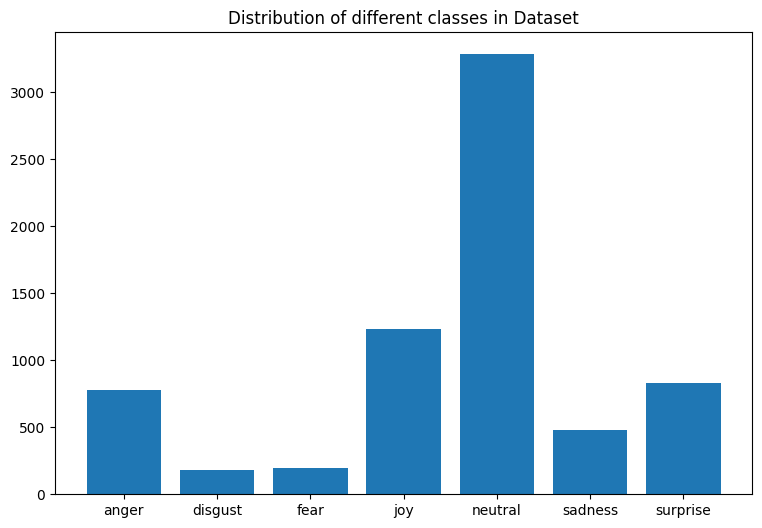

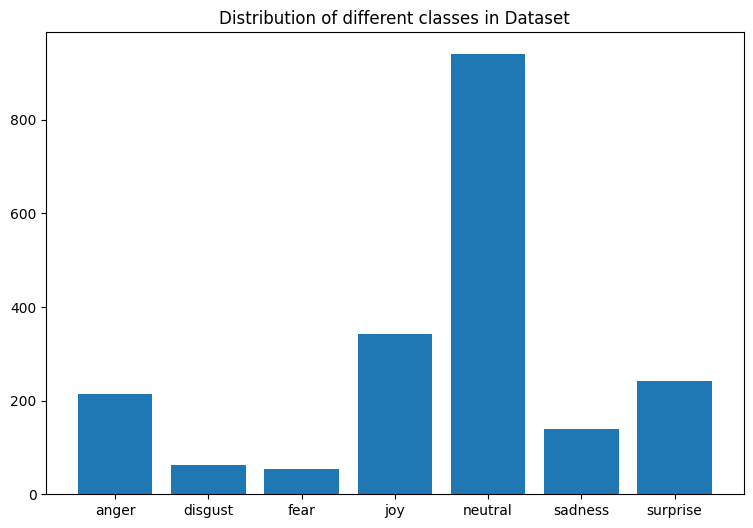

FileNotFoundError: [WinError 3] The system cannot find the path specified: './test_mfcc_all//anger/'

In [98]:
dir = "./train_mfcc_label/"
dir_val = './val_mfcc_label/'
dir_test = './test_mfcc_all/'

show_distribution(dir)
show_distribution(dir_val)
show_distribution(dir_test)

In [41]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [60]:
img_height, img_width = 300, 300
train_dir = dir
valid_dir = dir_val
num_classes = len(os.listdir(os.path.join(train_dir)))
batch_size = 32

In [61]:
train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   zoom_range=0.4)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))

Found 6984 images belonging to 7 classes.


In [62]:
validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_directory(valid_dir,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 1996 images belonging to 7 classes.


In [82]:
print(img_height)
print(img_width)

100
100


In [84]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3), padding="same"),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    
    Conv2D(32, (3, 3), activation='relu', padding="same"),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu', padding="same"),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding="same"),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    #Conv2D(256, (3, 3), activation='relu', padding="same"),
    #Conv2D(256, (3, 3), activation='relu'),
    #MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding="same"),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(7, activation='softmax')
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 conv2d_46 (Conv2D)          (None, 98, 98, 16)        2320      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 49, 49, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 49, 49, 32)        4640      
                                                                 
 conv2d_48 (Conv2D)          (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                

In [85]:
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics =['accuracy'])

In [65]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [75]:
early_stops = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

best_model_file = './CNN_aug_best_weights.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [86]:
history = model.fit(train_generator,
                              epochs=50,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [best_model, reduce_lr, early_stops]
                              )

Epoch 1/50
219/219 [==============================] - ETA: 0s - loss: 1.5749 - accuracy: 0.4684
Epoch 1: val_accuracy did not improve from 0.47094
219/219 [==============================] - 595s 3s/step - loss: 1.5749 - accuracy: 0.4684 - val_loss: 1.5855 - val_accuracy: 0.4709 - lr: 0.0010
Epoch 2/50
219/219 [==============================] - ETA: 0s - loss: 1.5490 - accuracy: 0.4704
Epoch 2: val_accuracy did not improve from 0.47094
219/219 [==============================] - 202s 922ms/step - loss: 1.5490 - accuracy: 0.4704 - val_loss: 1.5465 - val_accuracy: 0.4709 - lr: 0.0010
Epoch 3/50
219/219 [==============================] - ETA: 0s - loss: 1.5502 - accuracy: 0.4704
Epoch 3: val_accuracy did not improve from 0.47094
219/219 [==============================] - 190s 869ms/step - loss: 1.5502 - accuracy: 0.4704 - val_loss: 1.5560 - val_accuracy: 0.4709 - lr: 0.0010
Epoch 4/50
219/219 [==============================] - ETA: 0s - loss: 1.5476 - accuracy: 0.4704
Epoch 4: val_accuracy 

In [77]:
from matplotlib import pyplot as plt

def show_accuracy(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc))

    fig = plt.figure(figsize=(14,7))
    plt.plot(epochs, acc, 'r', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc='lower right')
    plt.show()

In [78]:
from matplotlib import pyplot as plt

def show_loss(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc))

    fig2 = plt.figure(figsize=(14,7))
    plt.plot(epochs, loss, 'r', label="Training Loss")
    plt.plot(epochs, val_loss, 'b', label="Validation Loss")
    plt.legend(loc='upper right')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.show()

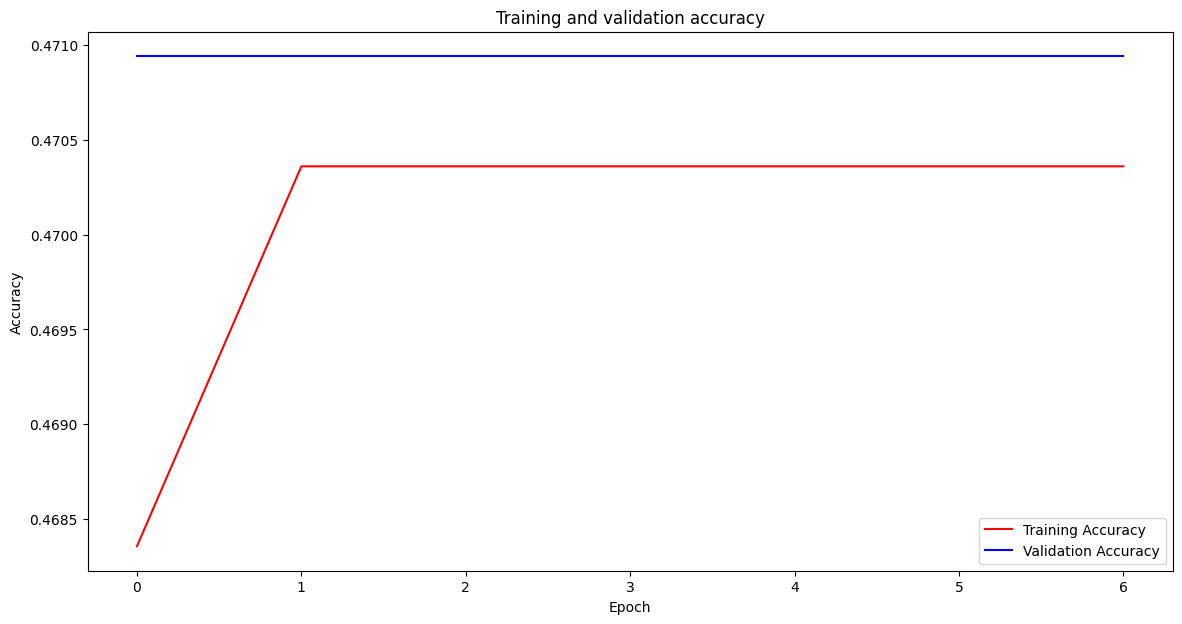

In [87]:
show_accuracy(history)

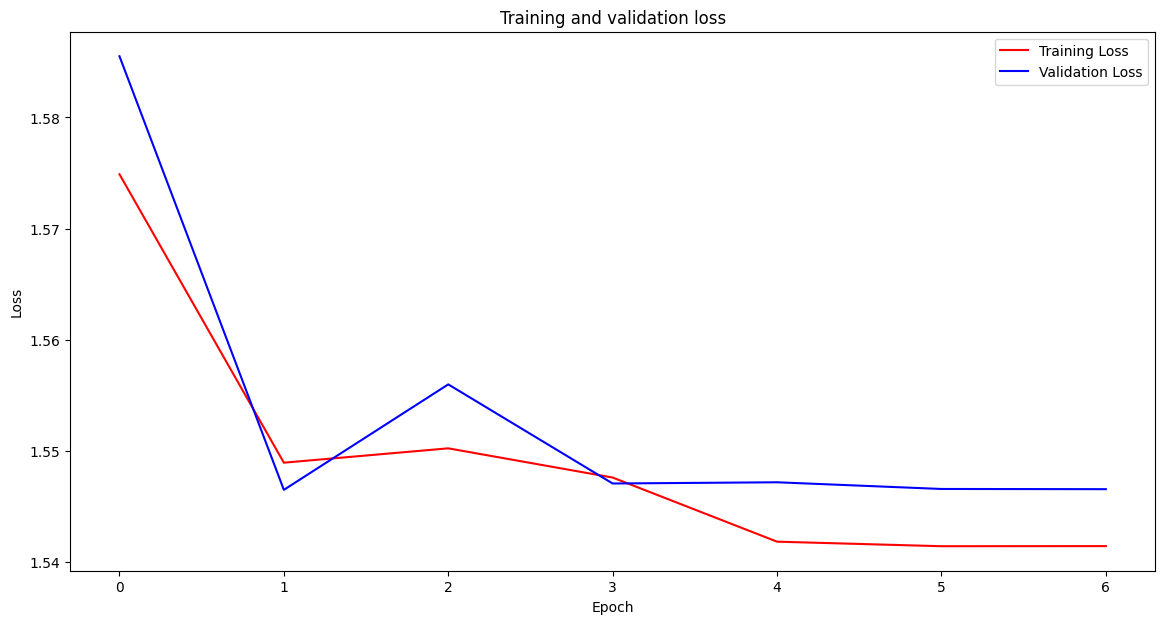

In [88]:
show_loss(history)

In [89]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

def preprocess_image(path):
    img = load_img(path, target_size = (img_height, img_width))
    a = img_to_array(img)
    a = np.expand_dims(a, axis = 0)
    a /= 255.
    return a

In [96]:
test_images_dir = os.path.join(dir_test)
test_df = pd.read_csv('./test_data.csv')

test_file = []
for index, row in test_df.iterrows():
    dialogue_id = str(row['Dialogue_ID'])  # Convert to string
    utterance_id = str(row['Utterance_ID'])
    test_file.append("dia" + dialogue_id + "_utt" + utterance_id + ".png")

test_ids = [str(item) for item in test_file]

test_images = [test_images_dir + item for item in test_ids]
test_preprocessed_images = np.vstack([preprocess_image(fn) for fn in test_images])
np.save('/content/test_preproc_CNN.npy', test_preprocessed_images)



FileNotFoundError: [Errno 2] No such file or directory: './test_mfcc_label/dia530_utt0.png'

In [ ]:
array = model.predict(test_preprocessed_images, batch_size=1, verbose=1)
answer = np.argmax(array, axis=1)

In [ ]:
y_true = test_df['Emotion']
y_pred = array

In [ ]:
from sklearn.metrics import log_loss
loss = log_loss(y_true, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, answer)
conf_mat

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
    else:
        cm=cm


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
     


In [ ]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(37,14))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion matrix, without normalization')
plt.show()
     